#### Nhóm Sinh Viên báo cáo

21424028: Nguyễn An Khương

21424031: Mai Văn Long

21424057: Phan Văn Tình

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

In [ ]:
def edge_detection(image_path, blur_ksize=7, sobel_ksize=1, skipping_threshold=30):
    """
    image_path: link to image
    blur_ksize: kernel size parameter for Gaussian Blurry
    sobel_ksize: size of the extended Sobel kernel; it must be 1, 3, 5, or 7.
    skipping_threshold: ignore weakly edge
    """
    # read image
    img = cv2.imread(image_path)
    
    # convert BGR to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    
    # sobel algorthm use cv2.CV_64F
    sobelx64f = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    abs_sobel64f = np.absolute(sobelx64f)
    img_sobelx = np.uint8(abs_sobel64f)

    sobely64f = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    abs_sobel64f = np.absolute(sobely64f)
    img_sobely = np.uint8(abs_sobel64f)
    
    # calculate magnitude
    img_sobel = (img_sobelx + img_sobely)/2
    
    # ignore weakly pixel
    for i in range(img_sobel.shape[0]):
        for j in range(img_sobel.shape[1]):
            if img_sobel[i][j] < skipping_threshold:
                img_sobel[i][j] = 0
            else:
                img_sobel[i][j] = 255
    return img_sobel

In [ ]:
#Hiển thị hình ảnh gốc và ảnh đã qua edge detection
img = cv2.imread("in.pnm", 0)
# Find edge with Canny edge detection
edges = edge_detection("in.pnm")

# display results
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
#Hiển thị hình ảnh pnm
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

#### Thực thi build các phiên bản

In [ ]:
!nvcc "/content/drive/MyDrive/GPU/seamcarving_v1.cu" -o DA_1
!nvcc "/content/drive/MyDrive/GPU/seamcarving_v2.cu" -o DA_2
!nvcc "/content/drive/MyDrive/GPU/seamcarving_v3.cu" -o DA_3

'nvcc' is not recognized as an internal or external command,
operable program or batch file.
'nvcc' is not recognized as an internal or external command,
operable program or batch file.
'nvcc' is not recognized as an internal or external command,
operable program or batch file.


# 1. Mô tả ứng dụng

- Input: một tấm ảnh (đồ án này: ảnh RGB)

In [ ]:
show_pnm("in.pnm")

In [ ]:
!./DA_1 in.pnm 300

- Output: tấm ảnh được thay đổi kích thước mà không làm biến dạng các
đối tượng quan trọng (đồ án này: tấm ảnh được thu hẹp chiều rộng lại)

In [ ]:
show_pnm("300_host.pnm")

- Ý nghĩa thực tế của ứng dụng: một use case là ta có thể muốn có các
phiên bản với các kích thước khác nhau của cùng một tấm ảnh để hiển
thị trên các thiết bị khác nhau (máy tính, điện thoại, …)
- Ứng dụng này có cần tăng tốc không?
 + Cần, ứng dụng này chạy chậm khi cài đặt tuần tự

Ứng dụng thay đổi kích thước ảnh sử dụng thuật toán seam carving

#### Sau khi phân tích thuật toán seam carving, từ đó có những bước cần thực hiện sau:
1. Đọc file ảnh màu input.
2. Tiến hành chuyển ảnh màu sang ảnh xám.
3. Sử dụng bộ lọc, tính độ quan trọng của các pixel, từ đó tính toán được các pixel có độ quan trọng thấp nhất.
4. Tìm seam có độ quan trọng thấp nhất.
5. Xóa seam tìm được.
6. Lặp lại việc seam có độ quan trọng thấp nhất và xóa bỏ đến khi tìm được chiều dài mong mu

# 2. Cài đặt tuần tự

#### 1. Chuyển ảnh sang grayscale

$Grayscale = 0.299 * R + 0.587 * G + 0.114 * B$

In [ ]:
# Đọc ảnh PNM
image = Image.open("grb_to_gray_in.pnm")
image

#### 2. Tính độ quan trọng của mỗi pixel

- Thực hiện convolution giữa ảnh grayscale với bộ lọc x-Sobe(1)

| 1 | 0 | -1 |
|:-------|:------:|-------:|
| 2 | 0 | -2 |
| 1 | 0 | -1 |

Khi bộ lọc được áp lên một pixel trong ảnh(tâm của bộ lọc sẽ áp lên pixel đó), phép nhân giữa các giá trị của bộ lọc và các giá trị tương ứng của pixel trong vùng lân cận của pixel đó sẽ được thực hiện. Kết quả của phép nhân này sẽ được cộng lại để gán vào pixel hiện tại

- VD : vị trí hiện tại là i,j

| (1 * f(i-1,j-1)) | (0 * f(i-1,j)) | (-1 * f(i-1,j+1)) |
|:-------|:------:|-------:|
| (2 * f(i,j-1)) | (0 * f(i,j)) | (-2 * f(i,j+1)) |
| (1 * f(i+1,j-1)) | (0 * f(i+1,j)) | (-1 * f(i+1,j+1)) |

- Thực hiện convolution giữa ảnh grayscale với bộ lọc y-Sobe(2)


| 1 | 2 | 1 |
|:-------|:------:|-------:|
| 2 | 0 | 0 |
| -1 | -2 | -1 |

Độ quan trọng của một pixel =  |kết quả tương ứng của (1)| + |kết quả tương ứng của (2)|


#### 3. Tìm seam ít quan trọng nhất từ độ quan trọng của mỗi pixel

- Bắt đầu từ height - 1 chúng ta sẽ tính tổng pixel hiện tại với 3 pixel ở hàng height + 1 (trái dưới - dưới - phải dưới) nếu tổng pixel là nhỏ nhất thì ta sẽ lấy giá trị đó làm pixel

- VD: pixel hiện tại là 3: 
 3 + 5 = 8 > 3 + 3 = 6

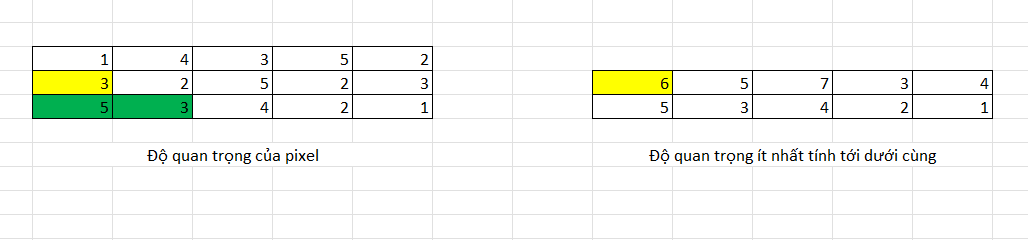
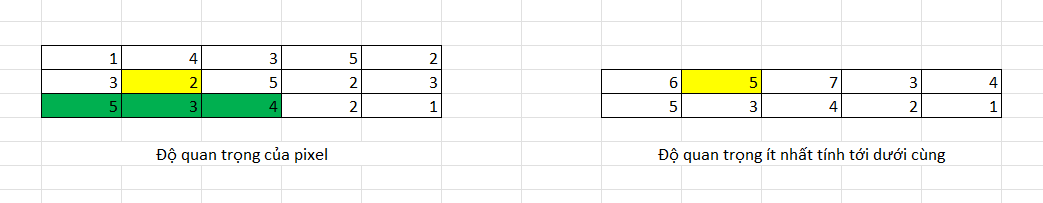

- Cứ tiếp tục làm cho đến khi height = 0 thì ta sẽ có mảng pixel như sau

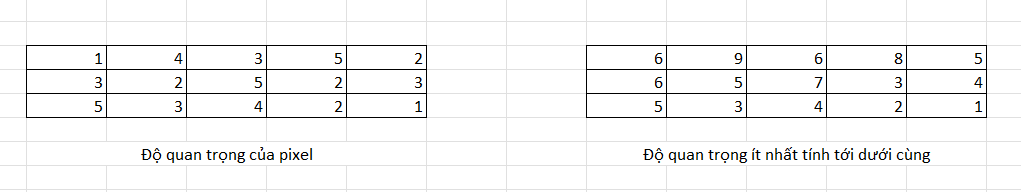

- Sau đó ta sẽ đi tìm seam ít quan trọng nhất từ độ quan trọng của các pixel
- Seam ít quan trọng nhất là seam có tổng pixel kề(dưới trái - dưới - dưới phải) là nhỏ nhất
- Lấy pixel nhỏ nhất của row đầu sau đó so sánh với 3 pixel (dưới trái, dưới, dưới phải) và lấy pixel nhỏ nhất, lặp lại tới height thì dừng

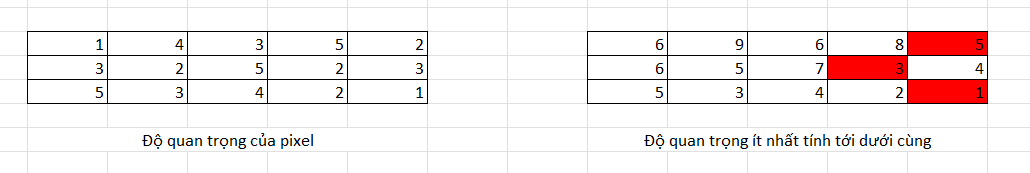

#### 4. Xóa seam ít quan trọng nhất

- Sau khi xóa seam ít quan trọng nhất dồn các pixel về trái

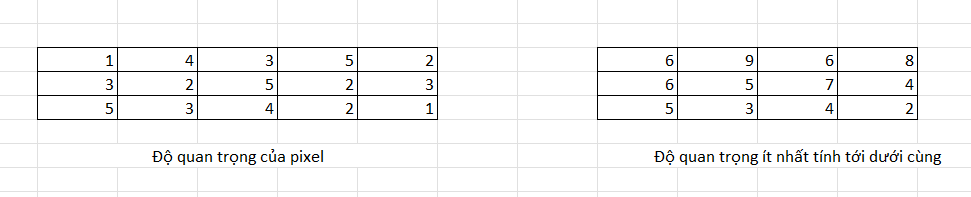

### Lặp lại quá trình từ bước 1 đến bước 4 cho đến khi thu hẹp được chiều rộng như mong muốn

Chạy thử thu hẹp chiều rộng bức hình xuống còn 500

In [ ]:
!./DA_1 in.pnm 500

In [ ]:
show_pnm("500_host.pnm")

Chạy thử thu hẹp chiều rộng bức hình xuống còn 400

In [ ]:
!./DA_1 in.pnm 400

In [ ]:
show_pnm("400_host.pnm")

# 3 .Cài đặt song song

### Để tăng tốc độ thực hiện seam carving, có thể song song hóa các bước sau:


- Bước chuyển ảnh sang grayscale không thực sự cần thiết cho quá trình seam carving, nhưng nó có thể được thực hiện song song để tăng tốc độ tính toán.

- Tính độ quan trọng của từng pixel trong ảnh: Bước tính độ quan trọng của từng pixel có thể được song song hóa bằng cách chia ảnh thành các phần nhỏ và tính độ quan trọng của từng phần đó trên các thread khác nhau. Sau đó, kết quả có thể được tổng hợp lại để tính toán độ quan trọng của toàn bộ ảnh.

- Tìm seam ít quan trọng nhất: Bước tìm seam ít quan trọng nhất có thể được song song hóa bằng cách sử dụng thuật toán tìm kiếm đường đi ít quan trọng nhất trên nhiều thread đồng thời. Mỗi thread sẽ tìm kiếm một phần của ảnh và trả về seam có độ quan trọng nhỏ nhất trên phần đó. Sau đó, các seam được so sánh để tìm ra seam có độ quan trọng nhỏ nhất trên toàn bộ ảnh.

# 4 .Cài đặt tối ưu hóa

 - Tối ưu hóa hàm convert từ ảnh RGB sang ảnh xám
 - Tính độ quan trọng của các pixel (sử dụng cache memory ở v3 cho tham số x filter, y filter)
 - Lấy các pixel có độ quan trọng thấp nhất
 - Tìm seam có độ quan trọng nhỏ nhất (sử dụng share memory ở v2)

In [ ]:
!./DA_2 in.pnm 400

In [ ]:
!./DA_3 in.pnm 400

# 5. So sánh kết quả thực hiện ở các version.
- So sánh kết quả chạy tuần tự và song song:
- So sánh kết quả chạy song song version 1 và version 2:
- So sánh kết quả chạy song song version 2 và version 3: